#Data Mining Project

Team Members : Swastika Tiwari, Himanshu Yadav

Faculty Advisor : Prof Sharanjeet Kaur

**Problem Statement :** This project focuses on developing machine learning models to accurately classify websites as phishing, or legitimate based on extracted URL features, aiming to enhance early detection and prevention of phishing attacks.

**Objective :** To identify the most influential features and build models with high accuracy to assist in automated phishing detection systems.

In [1]:
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=5b9c9442b822976b7096b7aed5027a1a164c03aa54823a9745274501bd6a1a11
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


#####Importing dependecies

In [2]:
import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

#####Reading Data

Initially, our dataset is in arff(Attribute-Relation File Format) format which is mainly used with Weka, a popular machine learning software.

**Structure of an ARFF file:**
It is basically a plain text file having two main section.
1. Header Section (meta-info)
2. Data Section (actual data)

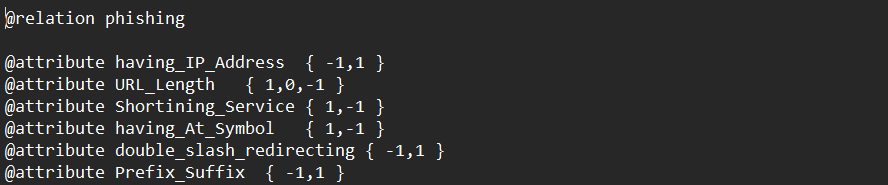

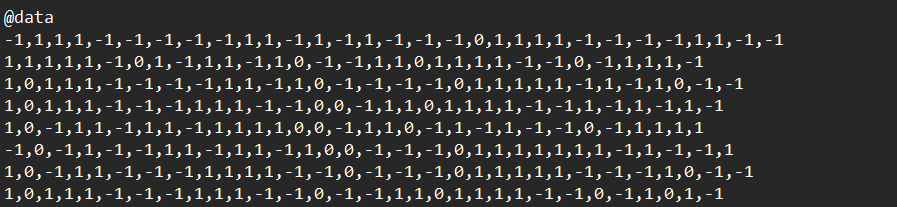

In [3]:
# Load ARFF file
with open("Training Dataset.arff") as f:
    dataset = arff.load(f)

# Convert to pandas DataFrame
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])


#####Keeping Important Attributes

**Labels meaning :**

-1 : Phishing
0 : Suspicious
1 : Legitimate

Reasons for keeping the attributes :

having_IP_Address :	Phishing sites often use raw IPs instead of domain names to avoid domain registration. This is a strong lexical indicator of suspicious URLs. {-1, 1}

URL_Length : Long URLs are used to confuse users, hide malicious parts, or mimic legit sites. A good heuristic across phishing datasets. To ensure the accuracy, the average length of URL is calculated i.e., 54 so URLhaving length greater than 54 is marked as phishing. {-1, 0, 1}

having_At_Symbol : The @ symbol in URLs can redirect users and hide the real domain, a classic phishing trick. {-1, 1}

double_slash_redirecting : Additional // after the protocol can be used to mask the real URL path, misleading users. {-1, 1}

SSLfinal_State : Phishing sites may show HTTPS, but often the certificate is self-signed, invalid, or issued by untrusted authorities. This feature helps detect insecure or fake SSL usage. Certificate Authorities that are consistently listed among the top trustworthy names include: “GeoTrust, GoDaddy, Network Solutions, Thawte, Comodo, Doster and VeriSign”. Furthermore, by testing out our datasets, the minimum age of a reputable certificate is two years. {-1, 0, 1}

Domain_registeration_length : Phishing domains are often registered for a very short time, unlike legitimate domains that last years. {-1, 1}


HTTPS_token	: Including "https" in the domain name (like https-secure-login.com) is a deception tactic, not a sign of security. {-1, 1}

Request_URL : Measures if the webpage’s images/scripts come from external domains. Phishing sites often don’t host their own images or scripts — they hotlink from the real site to appear genuine. Legitimate sites usually host these resources locally or via trusted CDNs. {-1, 1}

URL_of_Anchor	: Similar to Request_URL but for anchor tags (<a>). Phishing pages may redirect users using anchors pointing to unrelated/malicious domains. {-1, 0, 1}

SFH (Server Form Handler)	: Checks if form submissions go to external or empty handlers — often a sign of fake login pages in phishing sites. Real websites send form data to their own backend (e.g., https://bank.com/login_handler), not somewhere unrelated or missing. {-1, 0, 1}

popUpWidnow	: Phishing sites may trigger popups to mimic login prompts or block the browser UI. Less common now, but still informative. {-1, 1}

age_of_domain	: New domains are suspicious — legitimate businesses usually have older domains, while phishing domains are created recently. {-1, 1}

DNSRecord :	Checks if the domain has a valid DNS record. Nonexistent or expired DNS records can signal phishing domains. {-1, 1}

web_traffic	: Legitimate websites tend to have higher traffic, while phishing pages are often new and unknown. Since phishing websites live for a short period of time, they may not be recognized by the Alexa database. By reviewing our dataset, we find that legitimate websites ranked among the top 100,000. Furthermore, if the domain has no traffic or is not recognized by the Alexa database, it is classified as “Phishing”. Otherwise, it is classified as “Suspicious”. {-1, 0, 1}

Result : This is your target label (0 or 1) — not an input feature but used to train and test the model.

#####Dropping Irrelevant Attributes

Reasons for dropping :

Shortining_Service : This is almost always 1 for phishing and 0 for legitimate in the dataset. Including it may lead to data leakage or cause the model to overfit, reducing generalization to unseen attacks.

Prefix_Suffix : This feature checks for - in domain names. While useful, it's usually already captured by other lexical features like having_At_Symbol, URL_Length, and having_Sub_Domain.

having_Sub_Domain : It overlaps with domain parsing features. If having_Sub_Domain is highly correlated with other features, it becomes redundant and may even harm model performance.

Favicon : Checks where the small website icon (favicon) is coming from. This is often missing or not useful on mobile or new websites.

Port : Looks at which port the website is using (usually 80 or 443). Most sites use the same ports, so this doesn’t help much.

Links_in_tags	: This feature tends to be noisy in the dataset and is usually strongly correlated with features like Anchor_Tags, SFH, and Request_URL. Keeping all would add redundancy.

Submitting_to_email :	Although this can be useful, it's almost always 1 in phishing and 0 otherwise in this dataset—making it another too-perfect indicator, leading to overfitting or shortcut learning.

Abnormal_URL : This is a composite feature, derived from WHOIS data mismatches. But we are already using raw WHOIS-related attributes like DNSRecord, making this feature redundant or misleading.

Redirect : The feature can have ambiguous values (how many redirects are "bad"?), and in this dataset it often doesn't vary enough across classes to be useful.

on_mouseover : Looks for tricks that change link text when you hover over it. Modern browsers block this, so it’s less useful today.

RightClick : Checks if the website disables right-click to hide source code or URLs. This trick was common earlier, but modern phishing sites rarely use it now because users can inspect content using keyboard shortcuts or dev tools, blocking right-click often raises suspicion, legit sites (like online tests or streaming platforms) also disable right-click, causing false positives.

Iframe : Checks if the site loads other pages inside it. Again, old technique, not always used today, so might not help.

Page_Rank : Measures how important the website is on the internet. But it's hard to get in real-time, and might not be available for new sites.

Google_Index : Checks if the site shows up in Google search. Not all phishing sites are unindexed, and Google may index bad sites too.

Links_pointing_to_page : May correlate with Page_Rank and be noisy or inaccurate for newer/phishing sites which don’t have link history.

Statistical_report : Comes from external sources (like antivirus companies). If these reports are missing or slow, the model can’t work well.

In [4]:
pd.set_option('display.max_columns', None)
print(df)

df.drop(['Shortining_Service', 'Prefix_Suffix', 'having_Sub_Domain', 'Favicon', 'port', 'Links_in_tags', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'Iframe', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report'], axis = 1, inplace = True)
df

      having_IP_Address URL_Length Shortining_Service having_At_Symbol  \
0                    -1          1                  1                1   
1                     1          1                  1                1   
2                     1          0                  1                1   
3                     1          0                  1                1   
4                     1          0                 -1                1   
...                 ...        ...                ...              ...   
11050                 1         -1                  1               -1   
11051                -1          1                  1               -1   
11052                 1         -1                  1                1   
11053                -1         -1                  1                1   
11054                -1         -1                  1                1   

      double_slash_redirecting Prefix_Suffix having_Sub_Domain SSLfinal_State  \
0                           -1

,having_IP_Address,URL_Length,having_At_Symbol,double_slash_redirecting,SSLfinal_State,Domain_registeration_length,HTTPS_token,Request_URL,URL_of_Anchor,SFH,popUpWidnow,age_of_domain,DNSRecord,web_traffic,Result
0,-1,1,1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1
1,1,1,1,1,1,-1,-1,1,0,-1,1,-1,-1,0,-1
2,1,0,1,1,-1,-1,-1,1,0,-1,1,1,-1,1,-1
3,1,0,1,1,-1,1,-1,-1,0,-1,1,-1,-1,1,-1
4,1,0,1,1,1,-1,1,1,0,-1,-1,-1,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,-1,1,1,-1,1,1,1,-1,-1,1,1,-1,1
11051,-1,1,-1,-1,-1,-1,1,1,-1,0,-1,1,1,1,-1
11052,1,-1,1,1,-1,-1,1,1,0,-1,1,1,1,1,-1
11053,-1,-1,1,1,-1,1,1,-1,-1,-1,-1,1,1,1,-1


Dataset Shape :  (11055, 15)

Dataset Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   having_IP_Address            11055 non-null  object
 1   URL_Length                   11055 non-null  object
 2   having_At_Symbol             11055 non-null  object
 3   double_slash_redirecting     11055 non-null  object
 4   SSLfinal_State               11055 non-null  object
 5   Domain_registeration_length  11055 non-null  object
 6   HTTPS_token                  11055 non-null  object
 7   Request_URL                  11055 non-null  object
 8   URL_of_Anchor                11055 non-null  object
 9   SFH                          11055 non-null  object
 10  popUpWidnow                  11055 non-null  object
 11  age_of_domain                11055 non-null  object
 12  DNSRecord                    11055 non-nul

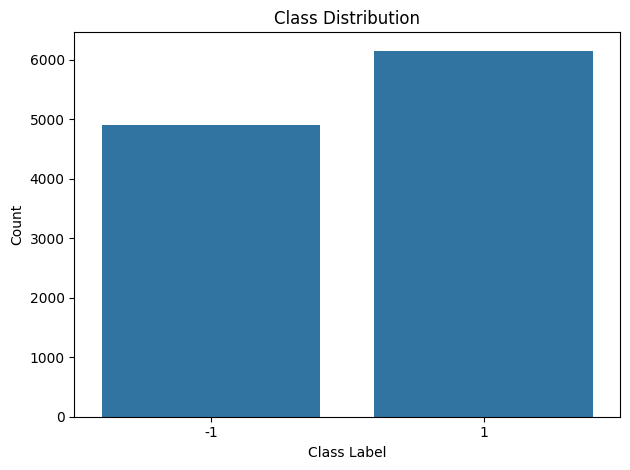

In [5]:
print("Dataset Shape : ", df.shape)
print("\nDataset Info : ")
print(df.info())

print("\nClass Distribution : \n")
sns.countplot(x='Result', data=df)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

####Data Splitting

In [6]:
x = df.drop('Result', axis = 1)
y = df['Result']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 11, stratify = y)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

##Decision Tree Classifier

###Hold-Out Method

In [7]:
dt_model1 = DecisionTreeClassifier(random_state = 11)
dt_model1.fit(x_train, y_train)

dt_pred_y = dt_model1.predict(x_test)

print("Decision Tree Performance : ")
print("\nAccuracy : ", accuracy_score(y_test, dt_pred_y))
print("\nClassification Report : ")
print(classification_report(y_test, dt_pred_y))

Decision Tree Performance : 

Accuracy :  0.9294500723589001

Classification Report : 
              precision    recall  f1-score   support

          -1       0.92      0.92      0.92      1225
           1       0.94      0.93      0.94      1539

    accuracy                           0.93      2764
   macro avg       0.93      0.93      0.93      2764
weighted avg       0.93      0.93      0.93      2764



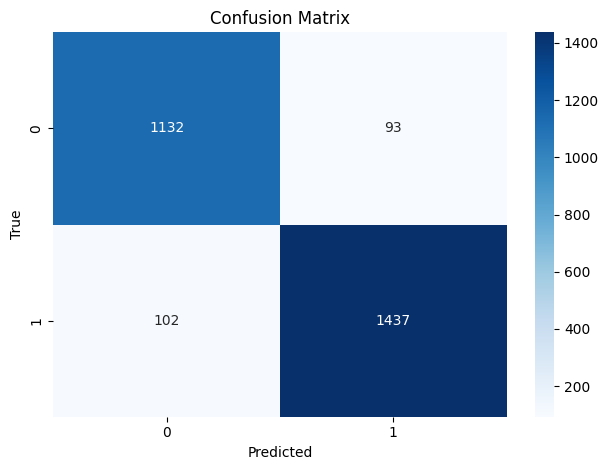

In [8]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, dt_pred_y)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

###Cross-validation Method

In [9]:
dt_model2 = DecisionTreeClassifier(random_state=11)
cv_scores = cross_val_score(dt_model2, x_train, y_train, cv=5, scoring='accuracy')
dt_model2.fit(x_train, y_train)
print("Cross-validation scores:", cv_scores)
print("Cross-validation mean accuracy:", cv_scores.mean())


dt_pred_y2 = dt_model2.predict(x_test)
print("\nDecision Tree Performance : ")
print("Accuracy : ", accuracy_score(y_test, dt_pred_y2))
print("\nClassification Report : ")
print(classification_report(y_test, dt_pred_y2))

#Evaluating on test set
test_accuracy = dt_model2.score(x_test, y_test)
print("Test set accuracy:", test_accuracy)

Cross-validation scores: [0.92766727 0.93727382 0.9384801  0.93606755 0.93667069]
Cross-validation mean accuracy: 0.9352318857334814

Decision Tree Performance : 
Accuracy :  0.9294500723589001

Classification Report : 
              precision    recall  f1-score   support

          -1       0.92      0.92      0.92      1225
           1       0.94      0.93      0.94      1539

    accuracy                           0.93      2764
   macro avg       0.93      0.93      0.93      2764
weighted avg       0.93      0.93      0.93      2764

Test set accuracy: 0.9294500723589001


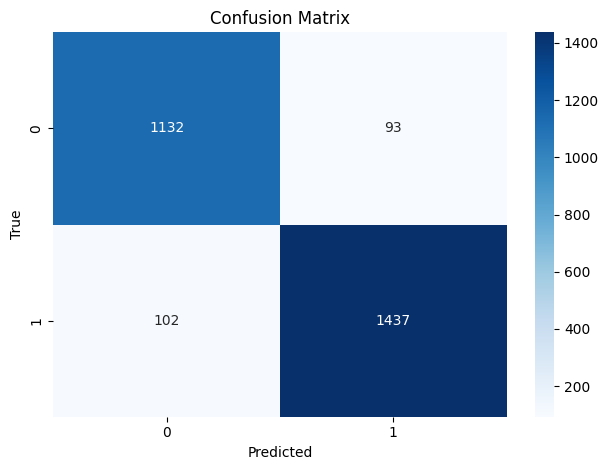

In [10]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, dt_pred_y2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

##K-Nearest Neighbors Classifier

In [11]:
#Computing Accuracy by taking value of k from 2 to 15
k_values = list(range(2, 16))
accuracies = []

for k in k_values:
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(x_train_scaled, y_train)
  knn_pred_y = knn_model.predict(x_test_scaled)
  accuracies.append(accuracy_score(y_test, knn_pred_y))

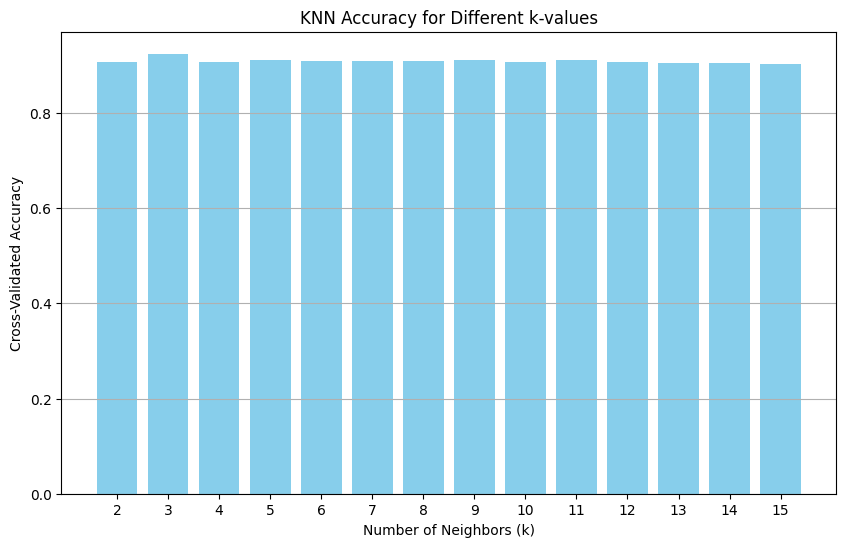

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(k_values, accuracies, color='skyblue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy for Different k-values')
plt.xticks(k_values)
plt.grid(axis='y')
plt.show()

Since the KNN model is returning high accuracy with k = 3, we will proceed with k = 3.

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_scaled, y_train)

knn_pred_y = knn_model.predict(x_test_scaled)

print("KNN Performance:")
print("Accuracy:", accuracy_score(y_test, knn_pred_y))
print(confusion_matrix(y_test, knn_pred_y))
print(classification_report(y_test, knn_pred_y))

KNN Performance:
Accuracy: 0.9243849493487699
[[1116  109]
 [ 100 1439]]
              precision    recall  f1-score   support

          -1       0.92      0.91      0.91      1225
           1       0.93      0.94      0.93      1539

    accuracy                           0.92      2764
   macro avg       0.92      0.92      0.92      2764
weighted avg       0.92      0.92      0.92      2764



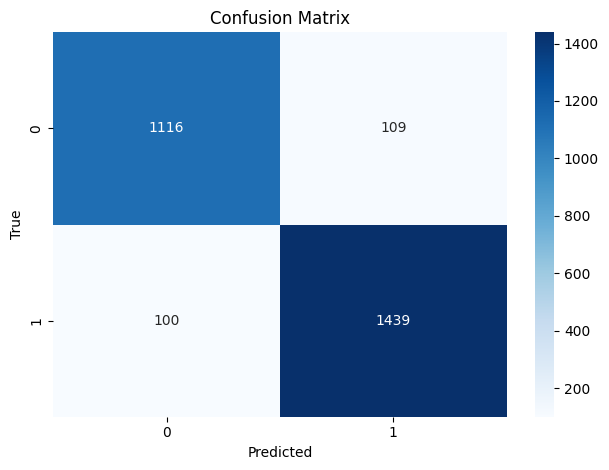

In [14]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, knn_pred_y)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

##Comparing Both Models

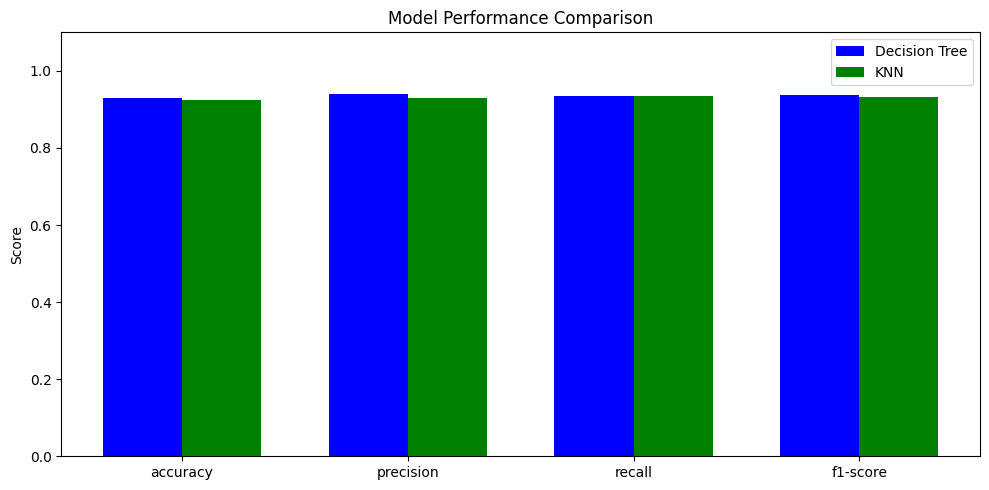

In [15]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Generate classification reports as dictionaries
dt_report = classification_report(y_test, dt_pred_y, output_dict=True)
knn_report = classification_report(y_test, knn_pred_y, output_dict=True)

# Extract metrics for the positive class '1'
metrics = ['precision', 'recall', 'f1-score']
dt_scores = [dt_report['1'][m] for m in metrics]
knn_scores = [knn_report['1'][m] for m in metrics]

# Also add accuracy
dt_accuracy = accuracy_score(y_test, dt_pred_y)
knn_accuracy = accuracy_score(y_test, knn_pred_y)

dt_scores.insert(0, dt_accuracy)
knn_scores.insert(0, knn_accuracy)
metrics.insert(0, 'accuracy')

# Plotting
z = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(z - width/2, dt_scores, width, label='Decision Tree', color='blue')
plt.bar(z + width/2, knn_scores, width, label='KNN', color='green')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(z, metrics)
plt.ylim(0, 1.1)
plt.legend()

plt.tight_layout()
plt.show()

Both the Decision Tree and KNN models perform well, achieving comparable accuracies of 92.94% and 92.43%, respectively.

##Conclusion

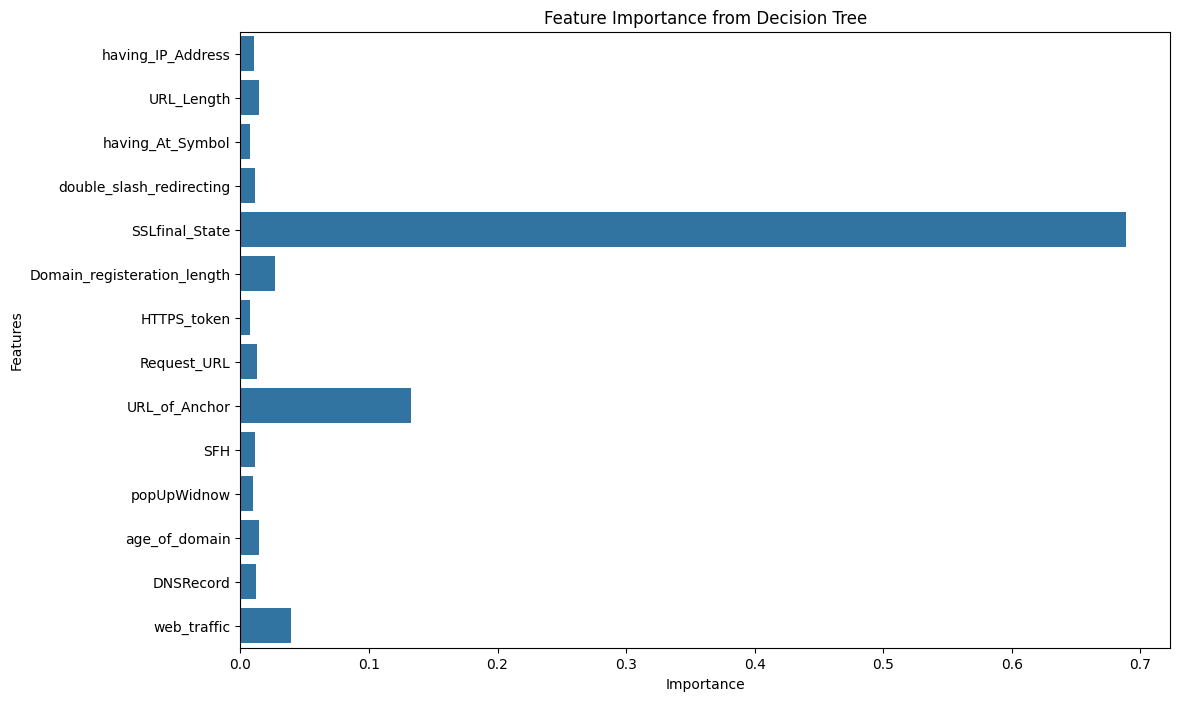

In [16]:
#Calculating Feature Importance
importances = dt_model1.feature_importances_
feature_names = x.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In the feature importance analysis, SSLfinal_State was observed to have a high importance score.
This indicates that the final state of a website's SSL certificate (Secure Sockets Layer) is one of the most critical factors in determining whether a website is phishing or legitimate.

A secure and valid SSLfinal_State suggests that the website is likely to be legitimate.

A missing, invalid, or suspicious SSLfinal_State strongly signals a phishing attempt.